In [22]:
import dalex as dx
import xgboost
import shap

import sklearn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import platform
print(f'Python {platform.python_version()}')

{package.__name__: package.__version__ for package in [dx, xgboost, shap, sklearn, pd, np]}

Python 3.11.6


{'dalex': '1.6.0',
 'xgboost': '2.0.1',
 'shap': '0.43.0',
 'sklearn': '1.3.2',
 'pandas': '2.1.2',
 'numpy': '1.26.1'}

### 0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.

In [3]:
!wget -nc https://raw.githubusercontent.com/adrianstando/imbalanced-benchmarking-set/main/datasets/churn.csv

File ‘churn.csv’ already there; not retrieving.



In [4]:
dataset = pd.read_csv('churn.csv', index_col=0)
dataset.head()

,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,TARGET
0,265.1,45.07,197.4,16.78,244.7,11.01,10.0,2.70,0
1,161.6,27.47,195.5,16.62,254.4,11.45,13.7,3.70,0
2,243.4,41.38,121.2,10.30,162.6,7.32,12.2,3.29,0
3,299.4,50.90,61.9,5.26,196.9,8.86,6.6,1.78,0
4,166.7,28.34,148.3,12.61,186.9,8.41,10.1,2.73,0


In [5]:
X = dataset.drop(columns='TARGET')
y = dataset.TARGET

In [6]:
model = xgboost.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 1. Calculate Permutation-based Variable Importance for the selected model.

In [35]:
explainer = dx.Explainer(model, X, y, verbose=False)

pvi = explainer.model_parts(random_state=42)
pvi.plot()

We can see that the most important variables are the ones responsible for minutes spent using the phone, especially minutes spent talking during the day. Charges for using the phone are way less important, with only night charge having any significant value. We should also note that the most important times of day in minutes spent are day, then evening, then "international", then night.

### 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

Let's try a Random Forest model:

In [11]:
model1 = sklearn.ensemble.RandomForestClassifier() # type: ignore
model1.fit(X, y)

dx.Explainer(model1, X, y, verbose=False).model_parts(random_state=42).plot()

Here the day > evening > international > night importance is the same, but variables responsible for charge for the service are way more important, almost on par with "minutes" variables. The apparent difference may come from the fact that "minutes" and "charge" variables are very dependent on each other, so their importances could be "shared" to some degree.

Now let's change some of the hyperparameters in the Random Forest Model:

In [15]:
model2 = sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='log_loss', max_features=1.0) # type: ignore
model2.fit(X, y)

dx.Explainer(model2, X, y, verbose=False).model_parts(random_state=42).plot()

What mostly changed is that "charge" variables got even more important. Other difference is that minutes spent during the night went up 2 places in importance, But the importances stayed mostly the same.

For the last model tested, let's see Gradient Boosting:

In [12]:
model3 = sklearn.ensemble.GradientBoostingClassifier() # type: ignore
model3.fit(X, y)

dx.Explainer(model3, X, y, verbose=False).model_parts(random_state=42).plot()

Here we have similar results to previous models, especially to the last one, where only evening minutes and charge and international minutes and charge swapped places in pairs.

### 3. For the tree-based model from (1), compare PVI with:

#### A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the feature_importances_ attribute in xgboost and sklearn.

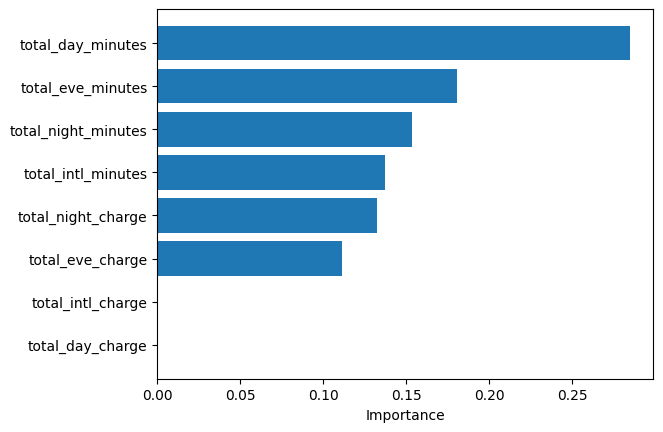

In [31]:
fig, ax = plt.subplots()


importances, labels = zip(*sorted(zip(model.feature_importances_, model.feature_names_in_)))

ax.barh(range(model.n_features_in_), importances)
ax.set_yticks(range(model.n_features_in_), labels=labels)
ax.set_xlabel('Importance')

plt.show()

Here we have almost the exact same importances as in (1), only with smaller range of the importances the variables take.

#### B) SHAP variable importance based on the TreeSHAP algorithm available in the shap package.

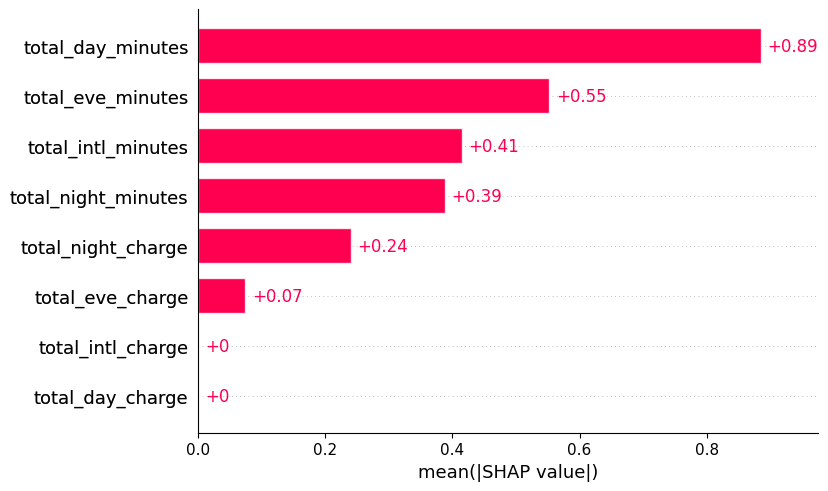

In [34]:
shap.plots.bar(shap.TreeExplainer(model)(X))

Again, the same ranking here, just with smaller differences between the values than in (1).